In [1]:
import os
import openai
import tiktoken

In [2]:
from dotenv import load_dotenv, find_dotenv
_ = load_dotenv(find_dotenv())

open.api_key = os.environ['OPENAI_API_KEY']

In [6]:
def complete_gpt_sentences(prompt, 
                           model="gpt-3.5-turbo",
                           temperature=0.7, 
                           max_tokens=200, 
                           stop=["."]):
    
    user_prompt = f'''Here is the first half of a sentence: '{prompt}'. 
    Complete it as one full sentence that is either a noun phrase or a sentential complement, not both. 
    A sentential complement is a clause that follows and completes the meaning of the main verb. 
    Generate the full sentence only.'''
    messages = [{'role': 'user', 'content': user_prompt}]
    response = openai.chat.completions.create(
        model=model,
        messages=messages,
        temperature=temperature,
        max_tokens=max_tokens,
        stop=stop
    )
    
    return response.choices[0].message.content

with open("no_cue_prompts.txt") as prompts_file:
    prompts = prompts_file.readlines()

    sentences_gpt = []
    for prompt in prompts:
        complete_sentence = complete_gpt_sentences(prompt.strip())
        sentences_gpt.append(complete_sentence)
        print(complete_sentence)

The employees understood the contract was binding
The mechanic accepted the car for repair
The old man recalled the nurse who had cared for him during his time in the hospital
The traveller heard the clock strike midnight
The worker maintained the walls with a fresh coat of paint
The apprentice forgot the bicycle in the garage
The committee mentioned the issue at their meeting
The army discovered the supplies hidden in the underground bunker
The umpire warned the spectators to stay back from the playing field
The artist discussed the concept of abstract expressionism
The teacher expressed the idea that students should work together on the group project
The gardener felt the plants with care
The employee believed the client's story
The detective found the clue in the abandoned house
The author rejected the plot due to its lack of originality
The man saw the doctor and received a clean bill of health
The historian explained the past events
The musician remembered the melody and hummed it

In [7]:
with open('sentences_gpt.txt', 'w') as f:
    for line in sentences_gpt:
        f.write("%s\n" % line)

In [8]:
def categorize_gpt_sentences(messages,
                model="gpt-3.5-turbo",
                temperature=0,
                max_tokens=3000):
    response = openai.chat.completions.create(
        model=model,
        messages=messages,
        temperature=temperature,
        max_tokens=max_tokens,
    )
    return response.choices[0].message.content

In [9]:
with open ("sentences_gpt.txt") as sentences: 
    sentences = ',\n'.join([
        f'{{"sentence": "{sentence}", "is_NP": true/false, "is_S": true/false}}'
        for sentence in sentences
    ])

system_message = """
Classify each sentence based on its grammatical structure by determining whether each sentence is a noun phrase (is_NP), 
or a sentential complement (is_S). 
A noun phrase acts as the direct object of the main verb, while a sentential complement acts as the embedded subject in an upcoming 
subordinate clause, it is a clause that follows and completes the meaning of the main verb.

Please provide your classification for each sentence in the JSON format, marking 'true' for the category that applies and 
'false' for those that do not. Each sentence should be classified into only one category.
Format for classification:

{
    "sentences": [
        """ + sentences + """
    ]
}
"""

messages = [
    {'role': 'system', 'content': system_message}
]

response = categorize_gpt_sentences(messages)
with open("categorize_gpt_sentences.json", "w") as file:
    file.write(response)

In [11]:
import nltk
from nltk import FreqDist
from nltk.tokenize import word_tokenize
import re
import json

In [30]:
with open("categorize_gpt_sentences.json") as gpt_sentences:    
    data = json.load(gpt_sentences)
    
    with open('np_gpt.txt', 'w') as f: 
        for sentence in data['sentences']:
            is_NP = sentence['is_NP']
            if is_NP:
                sentences = sentence['sentence'] 
                f.write("%s\n" % sentences)
                
    with open('s_gpt.txt', 'w') as f: 
        for sentence in data['sentences']:
            is_S = sentence['is_S']
            if is_S:
                sentences = sentence['sentence'] 
                f.write("%s\n" % sentences)

In [31]:
with open ("np_gpt.txt") as np_sentences, open ("s_gpt.txt") as s_sentences:
    gpt_np_sentences = np_sentences.read().lower()
    gpt_s_sentences = s_sentences.read().lower()
    
    gpt_np_tokens = nltk.word_tokenize(gpt_np_sentences)
    fdist_np_gpt = FreqDist(gpt_np_tokens)
    re_pattern = r'\w+'
    gpt_np_clean = []
    
    gpt_s_tokens = nltk.word_tokenize(gpt_s_sentences)
    fdist_s_gpt = FreqDist(gpt_s_tokens)
    re_pattern = r'\w+'
    gpt_s_clean = []
    
    for word in gpt_np_tokens:
        if re.match(re_pattern, word):
            gpt_np_clean.append(word)
            
    for word in gpt_s_tokens:
        if re.match(re_pattern, word):
            gpt_s_clean.append(word)

In [32]:
print(len(gpt_s_clean))

99


In [33]:
print(len(gpt_np_clean))

280


In [34]:
fdist_s_gpt.most_common(10)

[('the', 24),
 ('was', 3),
 ('would', 3),
 ('to', 2),
 ('that', 2),
 ('be', 2),
 ('hypothesis', 2),
 ('employees', 1),
 ('understood', 1),
 ('contract', 1)]

In [35]:
fdist_np_gpt.most_common(10)

[('the', 70),
 ('to', 8),
 ('in', 6),
 ('with', 6),
 ('a', 6),
 ('of', 6),
 ('man', 3),
 ('his', 3),
 ('and', 3),
 ('for', 2)]

In [3]:
open.api_key = os.environ['ANTHROPIC_API_KEY']
import anthropic

In [4]:
import time

def complete_claude_sentences(prompt):
    message = anthropic.Anthropic().messages.create(
        model="claude-3-haiku-20240307",
        temperature=0.7,
        max_tokens=200,
        stop_sequences=["."],
        messages=[
            {"role": "user", 
             "content": f"Here is the first half of a sentence: '{prompt}'. Complete it as one full sentence that is either a noun phrase or a sentential complement, not both. A sentential complement is a clause that follows and completes the meaning of the main verb. Generate the full sentence only."
            }
             ]
    )
    return message.content[0].text

with open("no_cue_prompts.txt") as prompts_file:
    prompts = prompts_file.readlines()   
    sentences_claude = []
    
    for prompt in prompts:
        complete_sentence = complete_claude_sentences(prompt.strip())
        sentences_claude.append(complete_sentence)
        print(complete_sentence)
        time.sleep(15)

The employees understood the contract that was presented to them
The mechanic accepted the car for repairs
The old man recalled the nurse tending to his ailing wife
The traveller heard the clock strike midnight
The worker maintained the walls until they were spotless
Sentential Complement:

The apprentice forgot the bicycle that he had left at the park
Sentential complement:
The committee mentioned the issue that the organization had been struggling with for years
The army discovered the supplies had been stolen
The umpire warned the spectators that they should refrain from heckling the players
The artist discussed the concept that his work was a reflection of the human experience
Sentential complement:

The teacher expressed the idea that the students should study more diligently
The gardener felt the plants were thriving in the warm sunlight
The employee believed the client was telling the truth
Sentential complement:

The detective found the clue that led to the suspect's arrest
The

In [5]:
with open('sentences_claude.txt', 'w') as f:
    for line in sentences_claude:
        f.write("%s\n" % line)

In [6]:
def categorize_claude_sentences():
    message = anthropic.Anthropic().messages.create(
        model="claude-3-haiku-20240307",
        temperature=0,
        max_tokens=3000,
        stop_sequences=["."],
        messages=[
            {"role": "user", 
             "content": system_message}
        ]
    )
    return message.content[0].text

with open ("sentences_claude.txt") as sentences: 
    sentences = ',\n'.join([
        f'{{"sentence": "{sentence}", "is_NP": true/false, "is_S": true/false}}'
        for sentence in sentences
    ])

system_message = """
Classify each sentence based on its grammatical structure by determining whether each sentence is a noun phrase (is_NP), 
or a sentential complement (is_S). 
A noun phrase acts as the direct object of the main verb, while a sentential complement acts as the embedded subject in an upcoming 
subordinate clause, introduced by conjunctions like "that" and often related to thoughts, speech, perception, or feelings. 
For example, in "She said that she was happy," "that she was happy" is a sentential complement.

Please provide your classification for each sentence in the JSON format, marking 'true' for the category that applies and 
'false' for those that do not. Each sentence should be classified into only one category.
Format for classification:

{
    "sentences": [
        """ + sentences + """
    ]
}
"""

response = categorize_claude_sentences()
with open("cateogrize_claude_sentences.json", "w") as file:
    file.write(response)

In [21]:
with open("cateogrize_claude_sentences.json") as claude_sentences:    
    data = json.load(claude_sentences)
    
    with open('np_claude.txt', 'w') as f: 
        for sentence in data['sentences']:
            is_NP = sentence['is_NP']
            if is_NP:
                sentences = sentence['sentence'] 
                f.write("%s\n" % sentences)
                
    with open('s_claude.txt', 'w') as f: 
        for sentence in data['sentences']:
            is_S = sentence['is_S']
            if is_S:
                sentences = sentence['sentence'] 
                f.write("%s\n" % sentences)

In [22]:
with open ("np_claude.txt") as np_sentences, open ("s_claude.txt") as s_sentences:
    claude_np_sentences = np_sentences.read().lower()
    claude_s_sentences = s_sentences.read().lower()
    
    claude_np_tokens = nltk.word_tokenize(claude_np_sentences)
    fdist_np_claude = FreqDist(claude_np_tokens)
    re_pattern = r'\w+'
    claude_np_clean = []
    
    claude_s_tokens = nltk.word_tokenize(claude_s_sentences)
    fdist_s_claude = FreqDist(claude_s_tokens)
    re_pattern = r'\w+'
    claude_s_clean = []
    
    for word in claude_np_tokens:
        if re.match(re_pattern, word):
            claude_np_clean.append(word)
            
    for word in claude_s_tokens:
        if re.match(re_pattern, word):
            claude_s_clean.append(word)

In [23]:
print(len(claude_s_clean))

184


In [24]:
print(len(claude_np_clean))

212


In [25]:
fdist_np_claude.most_common(10)

[('the', 51),
 ('that', 10),
 ('to', 5),
 ('was', 4),
 ('had', 4),
 ('man', 3),
 ('he', 3),
 ("'s", 3),
 ('student', 3),
 ('for', 2)]

In [26]:
fdist_s_claude.most_common(10)

[('the', 45),
 ('was', 10),
 ('that', 7),
 ('would', 4),
 ('a', 3),
 ('should', 2),
 ('of', 2),
 ('in', 2),
 ('be', 2),
 ('severe', 2)]

In [36]:
gpt_count_np = 0
gpt_count_s = 0

with open("np_gpt.txt") as gpt_np, open("s_gpt.txt") as gpt_s:
    for line in gpt_np:
        gpt_count_np += 1
    for line in gpt_s:
        gpt_count_s += 1

claude_count_np = 0
claude_count_s = 0

with open("np_claude.txt") as claude_np, open("s_claude.txt") as claude_s:
    for line in claude_np:
        claude_count_np += 1 
    for line in claude_s:
        claude_count_s += 1

In [28]:
from matplotlib import pyplot as plt
import numpy as np

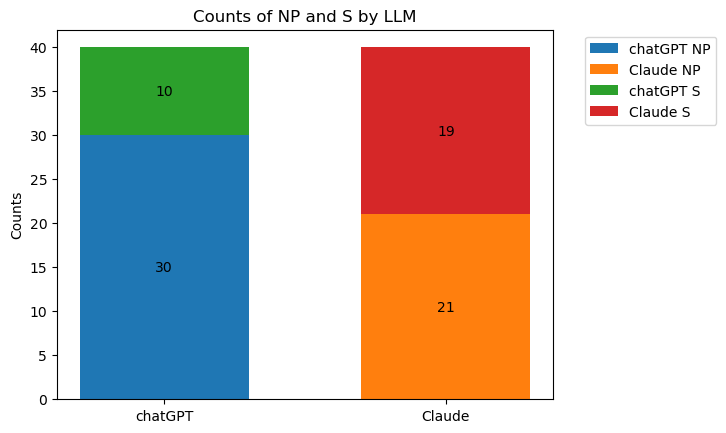

In [37]:
count_np = {
    'chatGPT': gpt_count_np,  
    'Claude': claude_count_np 
}
count_s = {
    'chatGPT': gpt_count_s,  
    'Claude': claude_count_s
}

LLMs = ['chatGPT', 'Claude']

width = 0.6
fig, ax = plt.subplots()

x = np.arange(len(LLMs))

bottom_np = np.zeros(len(LLMs))
bottom_s = np.zeros(len(LLMs))

for i, (LLM, count) in enumerate(count_np.items()):
    bars = ax.bar(x[i], count, width, label='{} NP'.format(LLM))
    bottom_np[i] += count
    ax.bar_label(bars, label_type='center')

for i, (LLM, count) in enumerate(count_s.items()):
    bars = ax.bar(x[i], count, width, label='{} S'.format(LLM), bottom=bottom_np[i])
    bottom_s[i] += count
    ax.bar_label(bars, label_type='center')

ax.set_ylabel('Counts')
ax.set_title('Counts of NP and S by LLM')
ax.set_xticks(x)
ax.set_xticklabels(LLMs)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()